In [39]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')

In [40]:
df = pd.read_csv('nlp-challenge.csv')

In [41]:
dct = {True: 1, False: -1}
df['Answer'] = df['Answer'].map(dct)

annotator_vectors = df.pivot_table(index='Annotator ID', columns='Text', values='Answer')
annotator_vectors.fillna(0, inplace=True)

In [42]:
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(annotator_vectors)

In [43]:
annotator_vectors['anomaly'] = clusters

# emb_train_cont.columns = emb_train_cont.columns.astype(str)

tsne = TSNE(n_components=2, random_state=42)
X_2d = tsne.fit_transform(annotator_vectors.drop('anomaly', axis=1))

In [52]:
fig = go.Figure(data=go.Scatter(
    x = X_2d[:, 0],
    y = X_2d[:, 1],
    mode='markers',  # Линии и маркеры
    text=annotator_vectors.index.values,  # Подписи
    marker=dict(
        size=8,
    )
))

fig.update_traces(textposition='top center')

fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [49]:
annotator_vectors.index.values

array(['A16184N1RO5OJV', 'A198H320N5MSXX', 'A19X8IA9EKC3XH',
       'A1DP551UV06FN6', 'A1G187YBG0DVMQ', 'A1M5BJTQIXCM33',
       'A1MG8KNVSVZ365', 'A1MJVTR0PCKBWW', 'A1R0689JPSQ3OF',
       'A1SN0UU3V61IIM', 'A1YSYI926BBOHW', 'A27W025UEXS1G0',
       'A292TFDMNVS0TP', 'A2A78DMGLC1S0Y', 'A2CJFO19NY4T5R',
       'A2GM5BW75YCKKW', 'A2GO2OXS4VM1PR', 'A2HM35CWB7IIFM',
       'A2JP9IKRHNLRPI', 'A2KHLJ2F58BEZK', 'A2LU259QPV1I4V',
       'A2QTL039A5VV3I', 'A2R25RH05K0B68', 'A2R28HXAEFKBPC',
       'A2VQBOJJ8HD6W9', 'A2WPHVMLLEV5ZB', 'A3124SRR191UIL',
       'A33B85TN97HQ33', 'A33Y36Y252Z30U', 'A3BCKNE5CWHODZ',
       'A3BISMR4GI02ZG', 'A3BJX6UUSOIKFN', 'A3HYCA7N5F6DL9',
       'A3MV3PT4TOO69P', 'A3OCJJMRKAIJZA', 'A9HQ3E0F2AGVO',
       'AAX9LTAOIBECD', 'AC95JAUAM2L2Z', 'AD1ILDUXZHASF', 'AG36U7IOG2LAP',
       'AGRYG65WJ1CKJ', 'AJQGWGESKQT4Y', 'AKQAI78JTXXC9', 'AKSJ3C5O3V9RB',
       'AKSLU0C30G3JT', 'AMYURTQIMAC8T', 'AOOF0H0EIEFFQ', 'AQIP3DSYXEXX5',
       'AR9AU5FY1S3RO', 'ARW1TCHCLEK1W', 'AX

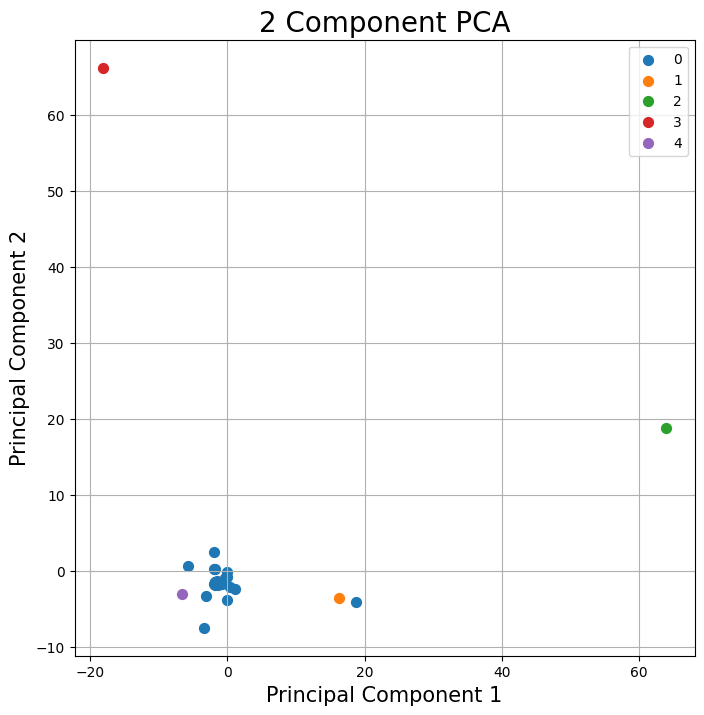

In [36]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(annotator_vectors)
principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize=15)
ax.set_ylabel('Principal Component 2', fontsize=15)
ax.set_title('2 Component PCA', fontsize=20)

colors = ['r', 'g', 'b', 'y', 'black']
for cluster, color in zip(np.unique(clusters), colors):
    indicesToKeep = (clusters == cluster)
    ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1']
               , principalDf.loc[indicesToKeep, 'principal component 2']
               , s = 50)
ax.legend(np.unique(clusters))
ax.grid()


In [19]:
data['Majority Answer'].value_counts()

Majority Answer
True     20467
False    15950
Name: count, dtype: int64

In [10]:
majority_answer = data.groupby('Text')['Answer'].agg(lambda x: x.value_counts().index[0])
data = data.join(majority_answer.rename('Majority Answer'), on='Text')
disagreement_ratio = (data[data['Answer'] != data['Majority Answer']].groupby('Annotator ID').size() / data.groupby('Annotator ID').size())

In [27]:
import pandas as pd
from sklearn.metrics import cohen_kappa_score



# Преобразуем столбец "Answer" в булев тип
data['Answer'] = data['Answer'].astype(bool)

# Список всех аннотаторов
annotators = data['Annotator ID'].unique()

# Датафрейм для хранения коэффициентов Каппа Коэна
kappa_df = pd.DataFrame(index=annotators, columns=annotators)

# Вычисляем коэффициент Каппа Коэна для каждой пары аннотаторов
for i in range(len(annotators)):
    for j in range(i+1, len(annotators)):
        # Извлекаем данные для каждого аннотатора
        annotator1 = data[data['Annotator ID'] == annotators[i]]
        annotator2 = data[data['Annotator ID'] == annotators[j]]
        # Оставляем только тексты, которые были аннотированы обоими аннотаторами
        common_texts = set(annotator1['Text']).intersection(set(annotator2['Text']))
        if len(common_texts) > 0:
            annotator1 = annotator1[annotator1['Text'].isin(common_texts)]['Answer']
            annotator2 = annotator2[annotator2['Text'].isin(common_texts)]['Answer']
            # Вычисляем коэффициент Каппа Коэна
            kappa = cohen_kappa_score(annotator1, annotator2)
            kappa_df.loc[annotators[i], annotators[j]] = kappa
            kappa_df.loc[annotators[j], annotators[i]] = kappa

print(kappa_df)


e:\Тестовые\istra_group\challenge\lib\site-packages\sklearn\metrics\_classification.py:697: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
e:\Тестовые\istra_group\challenge\lib\site-packages\sklearn\metrics\_classification.py:697: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
e:\Тестовые\istra_group\challenge\lib\site-packages\sklearn\metrics\_classification.py:697: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
e:\Тестовые\istra_group\challenge\lib\site-packages\sklearn\metrics\_classification.py:697: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
e:\Тестовые\istra_group\challenge\lib\site-packages\sklearn\metrics\_classification.py:697: RuntimeWarning: invalid value encountered in scalar divide
  k = np.

               A1MG8KNVSVZ365 A3OCJJMRKAIJZA AQIP3DSYXEXX5 A3MV3PT4TOO69P  \
A1MG8KNVSVZ365            NaN        0.02168     -0.033777      -0.033403   
A3OCJJMRKAIJZA        0.02168            NaN     -0.013544      -0.044847   
AQIP3DSYXEXX5       -0.033777      -0.013544           NaN       0.012845   
A3MV3PT4TOO69P      -0.033403      -0.044847      0.012845            NaN   
AGRYG65WJ1CKJ       -0.011511       0.099511         0.132       0.108871   
AR9AU5FY1S3RO        0.111273      -0.180605     -0.341463       0.306804   
A2GM5BW75YCKKW      -0.100196      -0.111282      0.023289       0.391792   
A2LU259QPV1I4V       0.061267        -0.0347       0.11157       0.657858   
A2R25RH05K0B68       0.072289      -0.132743     -0.188679       0.444444   
AYTH0E5PUXWX8       -0.119122      -0.012344           0.0       0.198279   
A9HQ3E0F2AGVO        0.005111      -0.000361      0.046512       0.013849   
ARW1TCHCLEK1W       -0.071064       0.032731      0.029231        0.33036   

e:\Тестовые\istra_group\challenge\lib\site-packages\sklearn\metrics\_classification.py:697: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
e:\Тестовые\istra_group\challenge\lib\site-packages\sklearn\metrics\_classification.py:697: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
e:\Тестовые\istra_group\challenge\lib\site-packages\sklearn\metrics\_classification.py:697: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
e:\Тестовые\istra_group\challenge\lib\site-packages\sklearn\metrics\_classification.py:697: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


In [29]:
kappa_df

,A1MG8KNVSVZ365,A3OCJJMRKAIJZA,AQIP3DSYXEXX5,A3MV3PT4TOO69P,AGRYG65WJ1CKJ,AR9AU5FY1S3RO,A2GM5BW75YCKKW,A2LU259QPV1I4V,A2R25RH05K0B68,AYTH0E5PUXWX8,...,A2R28HXAEFKBPC,AKQAI78JTXXC9,A1YSYI926BBOHW,A19X8IA9EKC3XH,A1SN0UU3V61IIM,AMYURTQIMAC8T,A2KHLJ2F58BEZK,AD1ILDUXZHASF,A1G187YBG0DVMQ,A27W025UEXS1G0
A1MG8KNVSVZ365,NaN,0.02168,-0.033777,-0.033403,-0.011511,0.111273,-0.100196,0.061267,0.072289,-0.119122,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A3OCJJMRKAIJZA,0.02168,NaN,-0.013544,-0.044847,0.099511,-0.180605,-0.111282,-0.0347,-0.132743,-0.012344,...,NaN,NaN,-0.013772,0.008205,0.0,NaN,0.0,0.0,NaN,NaN
AQIP3DSYXEXX5,-0.033777,-0.013544,NaN,0.012845,0.132,-0.341463,0.023289,0.11157,-0.188679,0.0,...,NaN,NaN,-0.363636,0.0,NaN,NaN,NaN,NaN,NaN,NaN
A3MV3PT4TOO69P,-0.033403,-0.044847,0.012845,NaN,0.108871,0.306804,0.391792,0.657858,0.444444,0.198279,...,0.0,0.461538,0.0,0.0,NaN,0.188468,0.0,0.360252,1.0,NaN
AGRYG65WJ1CKJ,-0.011511,0.099511,0.132,0.108871,NaN,1.0,0.425414,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AR9AU5FY1S3RO,0.111273,-0.180605,-0.341463,0.306804,1.0,NaN,0.341743,0.870039,0.0,0.156448,...,NaN,0.0,NaN,NaN,NaN,0.44,NaN,0.673469,NaN,NaN
A2GM5BW75YCKKW,-0.100196,-0.111282,0.023289,0.391792,0.425414,0.341743,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A2LU259QPV1I4V,0.061267,-0.0347,0.11157,0.657858,NaN,0.870039,NaN,NaN,1.0,0.758512,...,NaN,0.4,0.682927,NaN,NaN,0.449095,0.442478,0.798137,1.0,NaN
A2R25RH05K0B68,0.072289,-0.132743,-0.188679,0.444444,NaN,0.0,0.0,1.0,NaN,0.705882,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AYTH0E5PUXWX8,-0.119122,-0.012344,0.0,0.198279,NaN,0.156448,NaN,0.758512,0.705882,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
